In [463]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from random import shuffle

## Initial Data Cleaning

In [189]:
# Ignore some columns while reading the data into pandas dataframe
data = pd.read_csv('./C_elegans_CRISPR_sgRNA_Database.csv', usecols=[0,1,3,5,6,8,9,10,11,12])

# Case consistency, make all uppercase
data['sgRNA'] = data['sgRNA'].str.upper()
# convert ; to , for consistency
data['sgRNA'] = data['sgRNA'].str.replace(',', ';') 
data['target_name'] = data['target_name'].str.replace('`','')

# For Large data needs to be optimized, very clumsy way of doing this.
# Seperating the sgRNA sequences if there is something to seperate
first_seq = []
second_seq = []
for i in data['sgRNA']:
    try:
        index_value = i.index(';')
    except ValueError:
        index_value = 0
        
    if index_value == 0:
        first_seq.append(i)
        second_seq.append('')
    elif index_value != 0:
        first_seq.append(i[:index_value])
        second_seq.append(i[index_value+2:])

# Add sequence columns naming 1 and 2
data['sgRNA-1'] = pd.Series(first_seq)
data['sgRNA-2'] = pd.Series(second_seq)

# drop the sgRNA column
data = data.drop('sgRNA', axis=1)
# Repositioning the columns 
data = data[['sgRNA-1', 'sgRNA-2',"target_name", "sgRNA_cut",
             "num_worms", "num_lines", "sgRNA_type", "promoter_used", 
             "cas9_type", "screening_method","repair_mechanism"]]

# Getting rid of paranthesis and contents inside in promoter_used
data['promoter_used'] = data['promoter_used'].str.replace(r'\([^)]*\)', '').str.strip()

# Fill NaNs with 0 and make sure everything stays integer.
data = data.fillna(0, downcast=int)


In [398]:
data.head()

,sgRNA-1,sgRNA-2,target_name,sgRNA_cut,num_worms,num_lines,sgRNA_type,promoter_used,cas9_type,screening_method,repair_mechanism
0,GATTCTCGCGATAACCACGGTGG,,rde-12,Yes,160,95,DNA,K09B11.12 U6 promoter,circular plasmid DNA,Positive selectable markers,NHEJ
1,GGACATTGACACTAAAATCAAGG,,dpy-13,Yes,40,1,DNA,K09B11.12 U6 promoter,circular plasmid DNA,PCR and/or DNA sequencing,NHEJ
2,GTTATGAAGCTGACGGCGGACGG,,dpy-13,Yes,35,3,DNA,K09B11.12 U6 promoter,circular plasmid DNA,phenotypic analysis,NHEJ
3,GGCAATGCTGAGTGACACGGTGG,,dpy-7,Yes,300,240,DNA,K09B11.12 U6 promoter,circular plasmid DNA,phenotypic analysis,NHEJ
4,GCTACCATAGGCACCACGAGCGG,,dpy-10,Yes,250,246,DNA,K09B11.12 U6 promoter,circular plasmid DNA,phenotypic analysis,NHEJ


## Creating Features to Use in Simulation

---

### 1- Lengths of sgRNA sequences

In [192]:
def normalized_data(lst, size=50000):
    # Returns a normalized data using given list
    # as an effect of function it also plots the data
    
    s = np.std(lst)
    m = np.mean(lst)
    norm_lst = np.random.normal(m, s, size)

    # Plot the histogram.
    plt.hist(norm_lst, bins=25, normed=True, alpha=0.6, color='g')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, m, s)
    plt.plot(x, p, 'k', linewidth=2)
    plt.title("Normal Distribution of : mean = %.2f,  std = %.2f" % (m, s))
    plt.show()
    return norm_lst

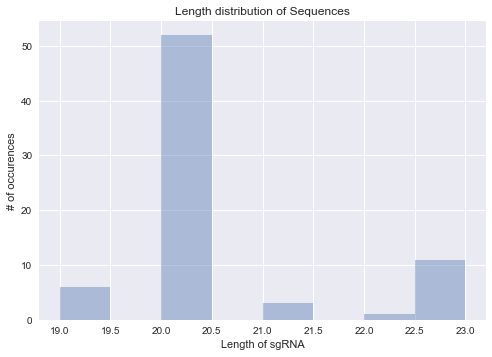

In [193]:
# Get all the lengths of sequences
lst_len = np.array(list(map(len, list(data['sgRNA-1']))))

# Plot the distribution of data
sns.distplot(lst_len, kde=False)
plt.title('Length distribution of Sequences')
plt.xlabel('Length of sgRNA')
plt.ylabel('# of occurences')
plt.show()

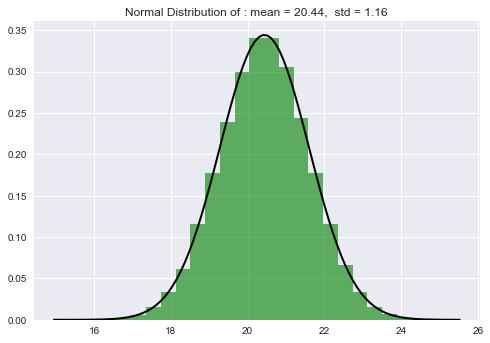

In [194]:
norm_len = normalized_data(lst_len, 50000)

---

### 2- GC contents of Sequences

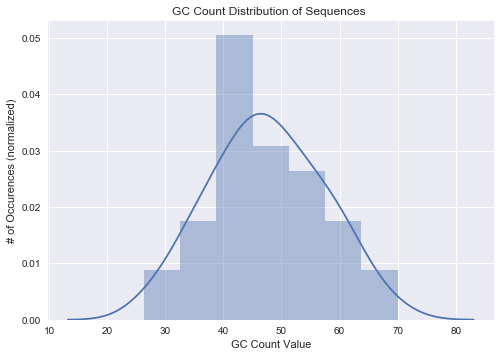

In [195]:
def calc_gc(sequence):
    # Calculates the GC content of given sequence
    return (sequence.count('G') + sequence.count('C')) / float(len(sequence)) * 100

# Get the gc counts of sgRNA sequences
gc_counts = list(map(calc_gc, list(data['sgRNA-1'])))

sns.distplot(gc_counts)
plt.title('GC Count Distribution of Sequences ')
plt.xlabel('GC Count Value')
plt.ylabel('# of Occurences (normalized)')
plt.show()

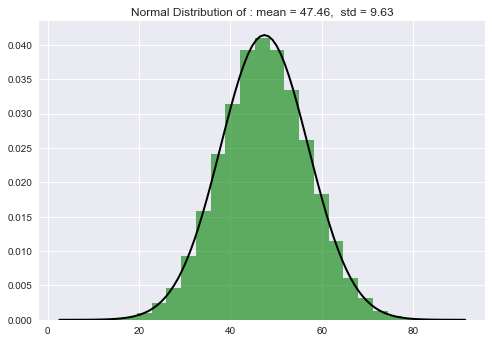

In [196]:
norm_gcs = normalized_data(gc_counts, 50000)

---

### 3 - Melting Temperatures of Sequences

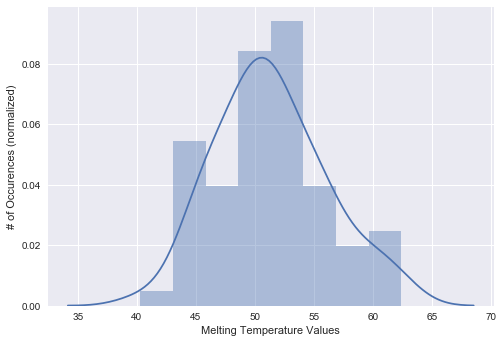

In [197]:
# Melting Temperature = 64.9 +41*(yG+zC-16.4)/(wA+xT+yG+zC)
def melt_temp(sequence):
    yG = sequence.count('G')
    zC = sequence.count('C')
    wA = sequence.count('A')
    xT = sequence.count('T')
    return (64.9 + (41 * ((yG+zC-16.4)/(wA+xT+yG+zC))))

melting_temps = list(map(melt_temp, list(data['sgRNA-1'])))

sns.distplot(melting_temps)
plt.xlabel('Melting Temperature Values')
plt.ylabel('# of Occurences (normalized)')
plt.show()

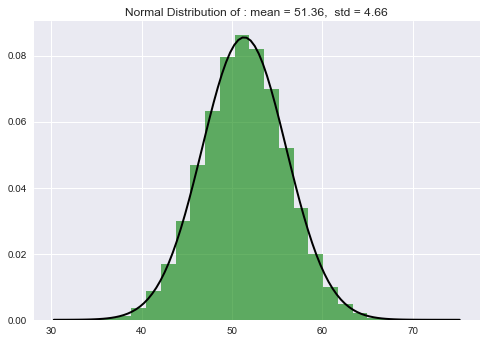

In [198]:
normalized_melt = normalized_data(melting_temps, 50000)

## Gene Names of C.elegans


In [167]:
from Bio import SeqIO

In [168]:
# Read fasta and create dataframe for genes for c.elegans
nm = []
sq = []
for i in SeqIO.parse('./genome.fa', 'fasta'):
    nm.append(i.name)
    tmp_seq = "".join((i.seq))
    sq.append(tmp_seq)

celegans_genes = pd.DataFrame()
celegans_genes['gene_name'] = pd.Series(nm)
celegans_genes['sequence'] = pd.Series(sq)

In [169]:
celegans_genes.head()

,gene_name,sequence
0,2L52.1a,atgtcaatggtaagaaatgtatcaaatcagagcgaaaaattggaaa...
1,2L52.1b,atgtcagataatgaagaagtatatgtgaacttccgtggaatgaact...
2,3R5.1b,atgttttcaccgctcgagtgtcgtcttgctgttgcttgtaaattcc...
3,4R79.1a,atgcttgaccacgttttgcttttaacctactgcttagtttcaactg...
4,4R79.1b,atgcattccgtcggattttggcacgaacactcgagagctgatcgcg...


In [170]:
# Read the GeneIDs for celegans
gene_df = pd.read_csv('./gene_IDs.txt', header=None, usecols=[2,3])
gene_df.columns = ['gene_id', 'gene_name']
gene_df.head()

,gene_id,gene_name
0,aap-1,Y110A7A.10
1,aat-1,F27C8.1
2,aat-2,F07C3.7
3,aat-3,F52H2.2
4,aat-4,T13A10.10


In [199]:
# merge dataframes by the gene_name
complete_gene_df = celegans_genes.join(gene_df.set_index('gene_name'), on='gene_name')

In [200]:
complete_gene_df.head()

,gene_name,sequence,gene_id
0,2L52.1a,atgtcaatggtaagaaatgtatcaaatcagagcgaaaaattggaaa...,NaN
1,2L52.1b,atgtcagataatgaagaagtatatgtgaacttccgtggaatgaact...,NaN
2,3R5.1b,atgttttcaccgctcgagtgtcgtcttgctgttgcttgtaaattcc...,NaN
3,4R79.1a,atgcttgaccacgttttgcttttaacctactgcttagtttcaactg...,NaN
4,4R79.1b,atgcattccgtcggattttggcacgaacactcgagagctgatcgcg...,NaN


In [203]:
used_genes = data.target_name.unique()
used_genes

array(['rde-12', 'dpy-13', 'dpy-7', 'dpy-10', 'dpy-6', 'rde-8', 'cdkl-1',
       'pat-2', 'pat-3', 'mei-1', 'ned-8', 'mel-26', 'cul-3', 'aspm-1',
       'cul-2', 'sas-7', 'ani-1', 'drp-1', 'ebp-2', 'apr-1', 'rap-3',
       'C52B11.5', 'pqn-82', 'C25A6.1', 'C25E10.12', 'T26C12.3', 'flp-32',
       'flp-8', 'K01G5.9', 'Y67D8C.3', 'kin-24', 'pry-1', 'T22C1.1',
       'Y54G2A.23', 'F18F11.5', 'F11A5.3', 'arl-3', 'unc-2', 'efk-1',
       'F01D4.9', 'C16A11.10', 'avr-15', 'ubr-1', 'nspc-1:7', 'Y79H2A.4',
       'T08B6.5', 'eif-3.G', 'srg-3:8', 'R08A2.2', 'W04C9.5', 'flp-9',
       'lgc-10', 'lgc-15', 'lgc-17', 'rsp-4', 'EEED8.4', 'EEED8.12',
       'lgc-31', 'C50B8.1', 'C25A1.4', 'lgc-45', 'C34D4.2'], dtype=object)

In [205]:
# Expand the gene_names since some is weirdly putted.
used_genes_exp = []
for i in used_genes:
    if ':' in i:
        start = int(i[-3:-2])
        end = int(i[-1:])
        for k in range(start, end+1):
            name = i[:-3] + str(k)
            used_genes_exp.append(name)
    else:
        used_genes_exp.append(i)   
used_genes_exp = np.array(used_genes_exp)
print(used_genes_exp)

['rde-12' 'dpy-13' 'dpy-7' 'dpy-10' 'dpy-6' 'rde-8' 'cdkl-1' 'pat-2'
 'pat-3' 'mei-1' 'ned-8' 'mel-26' 'cul-3' 'aspm-1' 'cul-2' 'sas-7' 'ani-1'
 'drp-1' 'ebp-2' 'apr-1' 'rap-3' 'C52B11.5' 'pqn-82' 'C25A6.1' 'C25E10.12'
 'T26C12.3' 'flp-32' 'flp-8' 'K01G5.9' 'Y67D8C.3' 'kin-24' 'pry-1'
 'T22C1.1' 'Y54G2A.23' 'F18F11.5' 'F11A5.3' 'arl-3' 'unc-2' 'efk-1'
 'F01D4.9' 'C16A11.10' 'avr-15' 'ubr-1' 'nspc-1' 'nspc-2' 'nspc-3' 'nspc-4'
 'nspc-5' 'nspc-6' 'nspc-7' 'Y79H2A.4' 'T08B6.5' 'eif-3.G' 'srg-3' 'srg-4'
 'srg-5' 'srg-6' 'srg-7' 'srg-8' 'R08A2.2' 'W04C9.5' 'flp-9' 'lgc-10'
 'lgc-15' 'lgc-17' 'rsp-4' 'EEED8.4' 'EEED8.12' 'lgc-31' 'C50B8.1'
 'C25A1.4' 'lgc-45' 'C34D4.2']


In [212]:
# Get the intersected gene_names
full_gene_names = complete_gene_df['gene_name'].values
gene_name_matches= np.intersect1d(used_genes_exp, full_gene_names)
gene_name_matches

array(['C16A11.10', 'C25A1.4', 'C25E10.12', 'C34D4.2', 'C50B8.1',
       'C52B11.5', 'EEED8.12', 'EEED8.4', 'F18F11.5', 'K01G5.9', 'R08A2.2',
       'T08B6.5', 'T22C1.1', 'Y54G2A.23'], dtype=object)

In [ ]:
# Replace NaN s with str 0, for type consistency
complete_gene_df['gene_id'].fillna('0')

In [213]:
# Get the intersected gene_ids
full_gene_ids = complete_gene_df['gene_id'].values
gene_id_matches = np.intersect1d(used_genes_exp, full_gene_ids)
gene_id_matches

array(['ani-1', 'aspm-1', 'dpy-13', 'dpy-6', 'dpy-7', 'ebp-2', 'flp-32',
       'flp-9', 'kin-24', 'ned-8', 'nspc-1', 'nspc-4', 'nspc-7', 'pat-2',
       'pat-3', 'pqn-82', 'pry-1', 'rap-3', 'rde-8', 'sas-7', 'ubr-1'], dtype=object)

In [216]:
len(used_genes_exp) - (len(gene_id_matches) + len(gene_name_matches))

38


Cleaning the Genes that does not have gene_ids

In [220]:
complete_gene_df = complete_gene_df[complete_gene_df['gene_id']!='0']
complete_gene_df = complete_gene_df.reset_index()

__Tips for selecting sgRNA:__

Through our own experience, we have identified additional tips for designing sgRNAs. We have found that the best sgRNAs for several tested genes have a G at position 1 and an A or T at position 17.

In [240]:
avg = np.mean(list(map(len, complete_gene_df['sequence'].values)))
print('The average of sequence lengths we have is', avg)

The average of sequence lengths we have is 1328.26313395


In [252]:
def kmer_counts(sequence, k=4):
    """Kmer counting function
    Inputs: 
        - DNA Sequence (string) (Mandatory)
        - kmer size (int) (default=4) 
    Output:
        - Dictionary that holds unique kmer (key) and occurences
    """
    kmers = {}
    for i in range(len(sequence) - k + 1):
       kmer = sequence[i:i+k]
       if kmer in kmers:
          kmers[kmer] += 1
       else:
          kmers[kmer] = 1
    return kmers
    # Uncomment when to print kmer and counts
#     for kmer, count in kmers.items():
#        print (kmer + "\t" + str(count))

In [248]:
x = {'A':4, 'B':5}

In [253]:
def unique_kmers(sequence, k=4):
    """Returns uinque kmers as a list using kmer_counts function"""
    kmer_dict = kmer_counts(sequence, k)
    return list(kmer_dict.keys())

In [254]:
example = (complete_gene_df['sequence'][0])

In [261]:
t = unique_kmers(example, 30)

In [270]:
def sgRNA_candidate_selector(all_kmers):
    """Returns candidate list that ensures following conditions"""
    candidate_lst = []
    for i in all_kmers:
        if i[0] != 'g' and (i[17] != 't' or i[17] != 'a'):
            continue

        else:
            candidate_lst.append(i)
    return candidate_lst

In [322]:
# Run through all the sequences and select sgRNA candidate selector
size = complete_gene_df.shape[0]
all_sgRNA = {}
for idx in range(size):
    if idx % 100 == 0:
        print("Looping through:", idx,"/", size)
    seq = complete_gene_df['sequence'][idx]
    gene = complete_gene_df['gene_name'][idx]
    candidates = sgRNA_candidate_selector(unique_kmers(seq, 30))
    if len(candidates) != 0:
        all_sgRNA[gene] = candidates

Looping through: 0 / 4397
Looping through: 100 / 4397
Looping through: 200 / 4397
Looping through: 300 / 4397
Looping through: 400 / 4397
Looping through: 500 / 4397
Looping through: 600 / 4397
Looping through: 700 / 4397
Looping through: 800 / 4397
Looping through: 900 / 4397
Looping through: 1000 / 4397
Looping through: 1100 / 4397
Looping through: 1200 / 4397
Looping through: 1300 / 4397
Looping through: 1400 / 4397
Looping through: 1500 / 4397
Looping through: 1600 / 4397
Looping through: 1700 / 4397
Looping through: 1800 / 4397
Looping through: 1900 / 4397
Looping through: 2000 / 4397
Looping through: 2100 / 4397
Looping through: 2200 / 4397
Looping through: 2300 / 4397
Looping through: 2400 / 4397
Looping through: 2500 / 4397
Looping through: 2600 / 4397
Looping through: 2700 / 4397
Looping through: 2800 / 4397
Looping through: 2900 / 4397
Looping through: 3000 / 4397
Looping through: 3100 / 4397
Looping through: 3200 / 4397
Looping through: 3300 / 4397
Looping through: 3400 / 43

In [323]:
len(all_sgRNA['F31E3.5'])

328

In [357]:
# Creating a dataframe
dummy_sgRNA = pd.DataFrame()

genes_lst = []
sgRNA_lst = []
for key in all_sgRNA.keys():
    for i in all_sgRNA[key]:
        genes_lst.append(key)
        sgRNA_lst.append(i.upper())
        
dummy_sgRNA['sgRNA'] = pd.Series(sgRNA_lst)
dummy_sgRNA['target_name'] = pd.Series(genes_lst)

In [358]:
dummy_sgRNA.shape

(1280830, 2)

In [359]:
dummy_sgRNA.head()

,sgRNA,target_name
0,GAGGCCCGTTTCACCGAGATCACCAACGAG,F31E3.5
1,GTCAAGTCCGTTGAGATGCATCACGAATCT,F31E3.5
2,GAGATCACCAACGAGGTTTCTGGATTCATC,F31E3.5
3,GCCCCAGGACATCGTGATTTCATCAAGAAC,F31E3.5
4,GAACATCCCAGGCCGATTGCGCCGTCTTGG,F31E3.5


### Further checks and filteration

1. Check GC Contents and select ```calc_gc(sequence)```
2. Check melting temperature and select ```melt_temp(sequence)```

In [360]:
# Adding corresponding scores of gc counts and melting temps
dummy_sgRNA['melting_temp'] = pd.Series(map(melt_temp, list(dummy_sgRNA['sgRNA'])))
dummy_sgRNA['gc_counts'] = pd.Series(map(calc_gc, list(dummy_sgRNA['sgRNA'])))

In [361]:
dummy_sgRNA.head()

,sgRNA,target_name,melting_temp,gc_counts
0,GAGGCCCGTTTCACCGAGATCACCAACGAG,F31E3.5,67.086667,60.000000
1,GTCAAGTCCGTTGAGATGCATCACGAATCT,F31E3.5,61.620000,46.666667
2,GAGATCACCAACGAGGTTTCTGGATTCATC,F31E3.5,61.620000,46.666667
3,GCCCCAGGACATCGTGATTTCATCAAGAAC,F31E3.5,62.986667,50.000000
4,GAACATCCCAGGCCGATTGCGCCGTCTTGG,F31E3.5,68.453333,63.333333


In [362]:
dummy_sgRNA.shape

(1280830, 4)

In [363]:
# Making sure that candidates are in between the real datas gc_counts and melting temps
dummy_sgRNA = dummy_sgRNA[((dummy_sgRNA['melting_temp'] > min(gc_counts)) & 
                           (dummy_sgRNA['melting_temp'] < max(gc_counts))) & 
                           ((dummy_sgRNA['gc_counts'] > min(melting_temps)) & 
                           (dummy_sgRNA['gc_counts'] < max(melting_temps))) ]

In [364]:
dummy_sgRNA.shape

(790200, 4)

In [369]:
len(dummy_sgRNA['sgRNA'].unique())

781980

In [371]:
dummy_sgRNA = dummy_sgRNA.drop_duplicates(['sgRNA'])

In [372]:
dummy_sgRNA.shape

(781980, 4)

In [386]:
dummy_sgRNA = dummy_sgRNA.reset_index(drop=True)

### Filtering further by looking at the PAM 

In [394]:
binary_truth = []
for i in range(dummy_sgRNA.shape[0]):
    seq = dummy_sgRNA['sgRNA'][i]
    # Checking the last 5 bp of 20 mid sequence for PAM
    sub_seq = seq[-10:-5]
    if 'GG' in sub_seq:
        if seq[4] == 'G':
            binary_truth.append(1)
        else: 
            binary_truth.append(0)
    else:
        binary_truth.append(0)
dummy_sgRNA['true_PAM'] = pd.Series(binary_truth)

In [395]:
dummy_sgRNA = dummy_sgRNA[dummy_sgRNA['true_PAM'] == 1].reset_index(drop=True)

In [397]:
dummy_sgRNA.shape

(32435, 5)

## simulating other Variables too

In [400]:
data.head()

,sgRNA-1,sgRNA-2,target_name,sgRNA_cut,num_worms,num_lines,sgRNA_type,promoter_used,cas9_type,screening_method,repair_mechanism
0,GATTCTCGCGATAACCACGGTGG,,rde-12,Yes,160,95,DNA,K09B11.12 U6 promoter,circular plasmid DNA,Positive selectable markers,NHEJ
1,GGACATTGACACTAAAATCAAGG,,dpy-13,Yes,40,1,DNA,K09B11.12 U6 promoter,circular plasmid DNA,PCR and/or DNA sequencing,NHEJ
2,GTTATGAAGCTGACGGCGGACGG,,dpy-13,Yes,35,3,DNA,K09B11.12 U6 promoter,circular plasmid DNA,phenotypic analysis,NHEJ
3,GGCAATGCTGAGTGACACGGTGG,,dpy-7,Yes,300,240,DNA,K09B11.12 U6 promoter,circular plasmid DNA,phenotypic analysis,NHEJ
4,GCTACCATAGGCACCACGAGCGG,,dpy-10,Yes,250,246,DNA,K09B11.12 U6 promoter,circular plasmid DNA,phenotypic analysis,NHEJ


### sgRNA_Cut column

In [403]:
sgRNA_cut_lst = data['sgRNA_cut'].map({'Yes': 1, 'No': 0})

In [431]:
data[data['sgRNA_cut'] == 'Yes'].shape[0]

63

In [432]:
pos_ratio = data[data['sgRNA_cut'] == 'Yes'].shape[0] / len(data['sgRNA_cut'])
neg_ratio = data[data['sgRNA_cut'] == 'No'].shape[0] / len(data['sgRNA_cut'])
print(pos_ratio, neg_ratio)

0.863013698630137 0.136986301369863


In [409]:
m = (sgRNA_cut_lst.values).mean()
std = (sgRNA_cut_lst.values).std()

In [419]:
x = np.array([int(i) for i in (np.random.normal(m, std, 32435))])

In [442]:
# Validating
int(np.ceil(pos_ratio*len(dummy_sgRNA))) + int(np.floor(neg_ratio*len(dummy_sgRNA)))

32435

In [468]:
pos_lst = []
neg_lst = []

In [469]:
pos_lst = [1] * int(np.ceil(pos_ratio*len(dummy_sgRNA)))

In [470]:
neg_lst = [0] * int(np.floor(neg_ratio*len(dummy_sgRNA)))

In [471]:
cut_lst = pos_lst + neg_lst

In [472]:
len(cut_lst)

32435

In [473]:
shuffle(cut_lst)

---

### num_worms

In [478]:
np.var(data['num_worms'].values)

3479.2084818915373

In [480]:
min(data['num_worms'].values)

9

In [481]:
m = np.mean(data['num_worms'].values)
sd = np.std(data['num_worms'].values)

In [489]:
exp_num_worms = np.random.randint(low=min(data['num_worms'].values), 
                                  high=max(data['num_worms'].values), 
                                  size=32435)

---
### num_lines

In [490]:
exp_num_lines = np.random.randint(low=min(data['num_lines'].values), 
                                  high=max(data['num_lines'].values), 
                                  size=32435)

In [492]:
dummy_sgRNA['sgRNA_cut'] = pd.Series(cut_lst)
dummy_sgRNA['num_worms'] = pd.Series(exp_num_worms)
dummy_sgRNA['num_lines'] = pd.Series(exp_num_lines)

In [495]:
dummy_sgRNA = dummy_sgRNA[['sgRNA', 'target_name', 'sgRNA_cut', 'num_worms', 'num_lines',
                             'melting_temp', 'gc_counts', 'true_PAM']]

In [499]:
dummy_sgRNA = dummy_sgRNA.drop(['melting_temp', 'gc_counts', 'true_PAM'], axis=1)

In [500]:
dummy_sgRNA.to_csv('./artificial_sgRNA_c_elegans_data.csv', index=None)